In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

# Most influential single words

In [26]:
def load_model(model_path):
    model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    return model, tokenizer

def predict_bias(model, tokenizer, article):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding=True, max_length=512)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        max_prob, predicted_idx = probabilities[0].max(dim=0)
        labels = ['left', 'center', 'right']
        predicted_bias = labels[predicted_idx.item()]
        confidence = max_prob.item()*100
        print(f'Predicted bias: {predicted_bias}\nConfidence: {confidence:.2f}%')
    return predicted_idx

def erasure_method(model, tokenizer, article):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding=True, max_length=512)
    original_idx = predict_bias(model, tokenizer, article)
    original_outputs = model(**inputs).logits[0, original_idx].item()
    
    def measure_importance(token_idx):
        altered_input = inputs.input_ids.clone()
        altered_input[0, token_idx] = tokenizer.unk_token_id
        with torch.no_grad():
            logits = model(input_ids=altered_input).logits
        return original_outputs - logits[0, original_idx].item()
    
    importances = [measure_importance(i) for i in range(inputs.input_ids.size(1))]
    sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)[:10]
    influential_words = [(tokenizer.decode([inputs.input_ids[0, idx]]), importances[idx]) for idx in sorted_indices]

    print("Top 10 influential words and their impacts:")
    for word, impact in influential_words:
        print(f"{word}: {impact:.4f}")

model_path = "article_bias_classifier"
model, tokenizer = load_model(model_path)

content= "Story highlights Obama says military assaults threaten what `` makes our military strong , ''\nFigures show the rate of assaults in the armed forces is increasing\nA number of officers at bases across the country are under investigation\nA rash of sexual assaults in the armed forces undermines Americans ' confidence in the military , President Barack Obama told newly commissioned officers at the U.S . Naval Academy Friday .\n`` Those who commit sexual assault are not only committing a crime , they threaten the trust and discipline that makes our military strong , '' Obama told the graduates , who were commissioned as Naval ensigns and Marine Corps second lieutenants .\n`` That 's why we have to be determined to stop these crimes . Because they have no place in the greatest military on Earth , '' Obama continued .\nThe president 's remarks came amid mounting outrage over sexual abuse cases in the armed forces . Figures show the rate of assaults in the armed forced increasing , and some top officers are under fire for condoning such acts .\nAt least two officers responsible for preventing sexual assault are under investigation for allegedly committing the types of act they were tasked with stopping .\nJUST WATCHED Fighting abuse in U.S. military ranks Replay More Videos ... MUST WATCH Fighting abuse in U.S. military ranks 09:08\nJUST WATCHED Did sergeant film female cadets ? Replay More Videos ... MUST WATCH Did sergeant film female cadets ? 01:43\nJUST WATCHED Confronting military sexual assault Replay More Videos ... MUST WATCH Confronting military sexual assault 02:15\nThose factors have led to calls for major changes in how the armed forces handle sexual assaults . Obama has demanded his top military brass `` leave no stone overturned '' in their quest to prevent abuse , and members of Congress have introduced legislation that would make it easier for victims to get justice .\nIn his commencement address Friday , Obama characterized the U.S. military as one of the few institutions Americans still trust , but said incidents like sexual assaults , as well as other delinquency by servicemen in the field , could erode that faith .\n`` Even in our military , we 've seen how the misconduct of some can have effects that ripple far and wide . In our digital age , a single image from the battlefield of troops falling short of their standards can go viral and endanger our forces and undermine our efforts to achieve security and peace , '' Obama told the Naval Academy graduates , 206 of whom were women .\nEarlier this month , the Department of Defense released figures estimating 26,000 cases of unwanted sexual contact occurred in 2012 , a 35 % jump from 2010 . Those cases ranged from groping to rape .\nThe vast majority of those incidents went unreported as crimes , the study showed .\nMeanwhile , officers at bases across the country are under investigation for allegedly committing sexual assaults .\nAn Army sergeant first class assigned to the sexual assault prevention unit at Fort Hood , Texas , came under investigation in early May for alleged sexual assault , pandering , abusive sexual contact and maltreatment of subordinates . The military said he 's been relieved of duty while investigators look in to the allegations .\nAlso in May , an Air Force officer who managed an assault prevention unit was charged with sexual battery and removed from duty . He is accused of grabbing a woman and groping her buttocks and breasts in an Arlington County parking lot not far from his Washington office .\nAnd this week , the Army said it had suspended Brig . Gen. Bryan Roberts , the top general at Fort Jackson in South Carolina , due to allegations of adultery and assault .\nFort Jackson is where most new Army recruits go through basic training , which includes training about sexual assault prevention .\nThe president traditionally delivers the commencement address at one of the military service academies every year . In 2012 he spoke at the Air Force Academy in Colorado Springs . The last time he delivered the commencement in Annapolis was 2009 .\nVice President Joe Biden spoke last weekend at the Coast Guard Academy in Connecticut . Defense Secretary Chuck Hagel will speak Saturday at the U.S. Military Academy at West Point , and also will address sexual assaults , according to a U.S. official .\nObama 's remarks came the day after a much-anticipated speech in which the president spelled out a new phase of America 's war on terror . He told the new officers Friday they are entering a military vastly changed from four years ago .\n`` Just as you have changed in the past four years , so too have the challenges facing our military , '' he said , noting the wars in Iraq and Afghanistan were still being engaged when Friday 's graduates entered the academy .\n`` Even as we move beyond deploying our large ground armies abroad , we need to conduct precise targeted strikes against terrorists before they kill our citizens , '' Obama said . `` Even as we stay vigilant in the face of terrorism , and stay true to our Constitution and values , we need to stay ready for the full range of threats . ''"
erasure_method(model, tokenizer, content)


Predicted bias: left
Confidence: 99.87%
Top 10 influential words and their impacts:
[SEP]: 0.5968
highlights: 0.2041
story: 0.1858
obama: 0.0310
what: 0.0192
of: 0.0177
sexual: 0.0175
commissioned: 0.0132
fighting: 0.0117
figures: 0.0111


----------------------------

# Most influential n-words

In [13]:
def load_model(model_path):
    model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model, tokenizer, device

def predict_bias(model, tokenizer, device, article):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = inputs.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        max_prob, predicted_idx = probabilities[0].max(dim=0)
        labels = ['left', 'center', 'right']
        predicted_bias = labels[predicted_idx.item()]
        confidence = max_prob.item()*100
        print(f'Predicted bias: {predicted_bias}\nConfidence: {confidence:.2f}%')
    return predicted_idx

def erasure_method(model, tokenizer, device, article, n_grams):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = inputs.to(device)
    original_idx = predict_bias(model, tokenizer, device, article)
    original_outputs = model(**inputs).logits[0, original_idx].item()
    
    def measure_importance(token_idx):
        if token_idx <= inputs.input_ids.size(1) - n_grams:
            altered_input = inputs.input_ids.clone()
            # Replace the tokens in the n-gram with the unknown tok
            for i in range(n_grams):
                altered_input[0, token_idx + i] = tokenizer.unk_token_id
            altered_input = altered_input.to(device)
            with torch.no_grad():
                logits = model(input_ids=altered_input).logits
            return original_outputs - logits[0, original_idx].item()
        return 0

    importances = []
    for i in tqdm(range(inputs.input_ids.size(1) - n_grams + 1)):
        importance = measure_importance(i)
        importances.append(importance)

    sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)[:10]
    influential_word_groups = [(tokenizer.decode(inputs.input_ids[0, idx:idx + n_grams]), importances[idx]) for idx in sorted_indices if importances[idx] > 0]

    print(f"Top 10 influential {n_grams}-word groups and their impacts:")
    for word_group, impact in influential_word_groups:
        print(f"{word_group}: {impact:.4f}")

model_path = "article_bias_classifier"
model, tokenizer, device = load_model(model_path)

content= "Story highlights Obama says military assaults threaten what `` makes our military strong , ''\nFigures show the rate of assaults in the armed forces is increasing\nA number of officers at bases across the country are under investigation\nA rash of sexual assaults in the armed forces undermines Americans ' confidence in the military , President Barack Obama told newly commissioned officers at the U.S . Naval Academy Friday .\n`` Those who commit sexual assault are not only committing a crime , they threaten the trust and discipline that makes our military strong , '' Obama told the graduates , who were commissioned as Naval ensigns and Marine Corps second lieutenants .\n`` That 's why we have to be determined to stop these crimes . Because they have no place in the greatest military on Earth , '' Obama continued .\nThe president 's remarks came amid mounting outrage over sexual abuse cases in the armed forces . Figures show the rate of assaults in the armed forced increasing , and some top officers are under fire for condoning such acts .\nAt least two officers responsible for preventing sexual assault are under investigation for allegedly committing the types of act they were tasked with stopping .\nJUST WATCHED Fighting abuse in U.S. military ranks Replay More Videos ... MUST WATCH Fighting abuse in U.S. military ranks 09:08\nJUST WATCHED Did sergeant film female cadets ? Replay More Videos ... MUST WATCH Did sergeant film female cadets ? 01:43\nJUST WATCHED Confronting military sexual assault Replay More Videos ... MUST WATCH Confronting military sexual assault 02:15\nThose factors have led to calls for major changes in how the armed forces handle sexual assaults . Obama has demanded his top military brass `` leave no stone overturned '' in their quest to prevent abuse , and members of Congress have introduced legislation that would make it easier for victims to get justice .\nIn his commencement address Friday , Obama characterized the U.S. military as one of the few institutions Americans still trust , but said incidents like sexual assaults , as well as other delinquency by servicemen in the field , could erode that faith .\n`` Even in our military , we 've seen how the misconduct of some can have effects that ripple far and wide . In our digital age , a single image from the battlefield of troops falling short of their standards can go viral and endanger our forces and undermine our efforts to achieve security and peace , '' Obama told the Naval Academy graduates , 206 of whom were women .\nEarlier this month , the Department of Defense released figures estimating 26,000 cases of unwanted sexual contact occurred in 2012 , a 35 % jump from 2010 . Those cases ranged from groping to rape .\nThe vast majority of those incidents went unreported as crimes , the study showed .\nMeanwhile , officers at bases across the country are under investigation for allegedly committing sexual assaults .\nAn Army sergeant first class assigned to the sexual assault prevention unit at Fort Hood , Texas , came under investigation in early May for alleged sexual assault , pandering , abusive sexual contact and maltreatment of subordinates . The military said he 's been relieved of duty while investigators look in to the allegations .\nAlso in May , an Air Force officer who managed an assault prevention unit was charged with sexual battery and removed from duty . He is accused of grabbing a woman and groping her buttocks and breasts in an Arlington County parking lot not far from his Washington office .\nAnd this week , the Army said it had suspended Brig . Gen. Bryan Roberts , the top general at Fort Jackson in South Carolina , due to allegations of adultery and assault .\nFort Jackson is where most new Army recruits go through basic training , which includes training about sexual assault prevention .\nThe president traditionally delivers the commencement address at one of the military service academies every year . In 2012 he spoke at the Air Force Academy in Colorado Springs . The last time he delivered the commencement in Annapolis was 2009 .\nVice President Joe Biden spoke last weekend at the Coast Guard Academy in Connecticut . Defense Secretary Chuck Hagel will speak Saturday at the U.S. Military Academy at West Point , and also will address sexual assaults , according to a U.S. official .\nObama 's remarks came the day after a much-anticipated speech in which the president spelled out a new phase of America 's war on terror . He told the new officers Friday they are entering a military vastly changed from four years ago .\n`` Just as you have changed in the past four years , so too have the challenges facing our military , '' he said , noting the wars in Iraq and Afghanistan were still being engaged when Friday 's graduates entered the academy .\n`` Even as we move beyond deploying our large ground armies abroad , we need to conduct precise targeted strikes against terrorists before they kill our citizens , '' Obama said . `` Even as we stay vigilant in the face of terrorism , and stay true to our Constitution and values , we need to stay ready for the full range of threats . ''"
erasure_method(model, tokenizer, device, content, n_grams=3)

Predicted bias: left
Confidence: 99.87%


100%|██████████| 510/510 [00:48<00:00, 10.55it/s]

Top 10 influential 3-word groups and their impacts:
2012, [SEP]: 0.5409
[CLS] story highlights: 0.2609
highlights obama says: 0.1694
story highlights obama: 0.1667
of sexual assaults: 0.0382
obama says military: 0.0357
far and wide: 0.0267
lieutenants.: 0.0256
newly commissioned officers: 0.0202
sexual assaults in: 0.0185


In [1]:
content= "Story highlights Obama says military assaults threaten what `` makes our military strong , ''\nFigures show the rate of assaults in the armed forces is increasing\nA number of officers at bases across the country are under investigation\nA rash of sexual assaults in the armed forces undermines Americans ' confidence in the military , President Barack Obama told newly commissioned officers at the U.S . Naval Academy Friday .\n`` Those who commit sexual assault are not only committing a crime , they threaten the trust and discipline that makes our military strong , '' Obama told the graduates , who were commissioned as Naval ensigns and Marine Corps second lieutenants .\n`` That 's why we have to be determined to stop these crimes . Because they have no place in the greatest military on Earth , '' Obama continued .\nThe president 's remarks came amid mounting outrage over sexual abuse cases in the armed forces . Figures show the rate of assaults in the armed forced increasing , and some top officers are under fire for condoning such acts .\nAt least two officers responsible for preventing sexual assault are under investigation for allegedly committing the types of act they were tasked with stopping .\nJUST WATCHED Fighting abuse in U.S. military ranks Replay More Videos ... MUST WATCH Fighting abuse in U.S. military ranks 09:08\nJUST WATCHED Did sergeant film female cadets ? Replay More Videos ... MUST WATCH Did sergeant film female cadets ? 01:43\nJUST WATCHED Confronting military sexual assault Replay More Videos ... MUST WATCH Confronting military sexual assault 02:15\nThose factors have led to calls for major changes in how the armed forces handle sexual assaults . Obama has demanded his top military brass `` leave no stone overturned '' in their quest to prevent abuse , and members of Congress have introduced legislation that would make it easier for victims to get justice .\nIn his commencement address Friday , Obama characterized the U.S. military as one of the few institutions Americans still trust , but said incidents like sexual assaults , as well as other delinquency by servicemen in the field , could erode that faith .\n`` Even in our military , we 've seen how the misconduct of some can have effects that ripple far and wide . In our digital age , a single image from the battlefield of troops falling short of their standards can go viral and endanger our forces and undermine our efforts to achieve security and peace , '' Obama told the Naval Academy graduates , 206 of whom were women .\nEarlier this month , the Department of Defense released figures estimating 26,000 cases of unwanted sexual contact occurred in 2012 , a 35 % jump from 2010 . Those cases ranged from groping to rape .\nThe vast majority of those incidents went unreported as crimes , the study showed .\nMeanwhile , officers at bases across the country are under investigation for allegedly committing sexual assaults .\nAn Army sergeant first class assigned to the sexual assault prevention unit at Fort Hood , Texas , came under investigation in early May for alleged sexual assault , pandering , abusive sexual contact and maltreatment of subordinates . The military said he 's been relieved of duty while investigators look in to the allegations .\nAlso in May , an Air Force officer who managed an assault prevention unit was charged with sexual battery and removed from duty . He is accused of grabbing a woman and groping her buttocks and breasts in an Arlington County parking lot not far from his Washington office .\nAnd this week , the Army said it had suspended Brig . Gen. Bryan Roberts , the top general at Fort Jackson in South Carolina , due to allegations of adultery and assault .\nFort Jackson is where most new Army recruits go through basic training , which includes training about sexual assault prevention .\nThe president traditionally delivers the commencement address at one of the military service academies every year . In 2012 he spoke at the Air Force Academy in Colorado Springs . The last time he delivered the commencement in Annapolis was 2009 .\nVice President Joe Biden spoke last weekend at the Coast Guard Academy in Connecticut . Defense Secretary Chuck Hagel will speak Saturday at the U.S. Military Academy at West Point , and also will address sexual assaults , according to a U.S. official .\nObama 's remarks came the day after a much-anticipated speech in which the president spelled out a new phase of America 's war on terror . He told the new officers Friday they are entering a military vastly changed from four years ago .\n`` Just as you have changed in the past four years , so too have the challenges facing our military , '' he said , noting the wars in Iraq and Afghanistan were still being engaged when Friday 's graduates entered the academy .\n`` Even as we move beyond deploying our large ground armies abroad , we need to conduct precise targeted strikes against terrorists before they kill our citizens , '' Obama said . `` Even as we stay vigilant in the face of terrorism , and stay true to our Constitution and values , we need to stay ready for the full range of threats . ''"

-------------------------------

# Without [CLS] and [SEP]

In [2]:
def load_model(model_path):
    model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model, tokenizer, device

def predict_bias(model, tokenizer, device, article):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = inputs.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        max_prob, predicted_idx = probabilities[0].max(dim=0)
        labels = ['left', 'center', 'right']
        predicted_bias = labels[predicted_idx.item()]
        confidence = max_prob.item()*100
        print(f'Predicted bias: {predicted_bias}\nConfidence: {confidence:.2f}%')
    return predicted_idx

def erasure_method(model, tokenizer, device, article, n_grams):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = inputs.to(device)
    original_idx = predict_bias(model, tokenizer, device, article)
    original_outputs = model(**inputs).logits[0, original_idx].item()
    
    def measure_importance(token_idx):
        if token_idx <= inputs.input_ids.size(1) - n_grams:
            altered_input = inputs.input_ids.clone()
            # Replace the tokens in the n-gram with the unknown tok
            for i in range(n_grams):
                altered_input[0, token_idx + i] = tokenizer.unk_token_id
            altered_input = altered_input.to(device)
            with torch.no_grad():
                logits = model(input_ids=altered_input).logits
            return original_outputs - logits[0, original_idx].item()
        return 0

    importances = []
    for i in tqdm(range(inputs.input_ids.size(1) - n_grams + 1)):
        importance = measure_importance(i)
        importances.append(importance)

    sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)[:10]
    influential_word_groups = [(tokenizer.decode(inputs.input_ids[0, idx:idx + n_grams]), importances[idx]) for idx in sorted_indices if importances[idx] > 0 and "[CLS]" not in tokenizer.decode(inputs.input_ids[0, idx:idx + n_grams]) and "[SEP]" not in tokenizer.decode(inputs.input_ids[0, idx:idx + n_grams])]

    print(f"Top 10 influential {n_grams}-word groups and their impacts:")

    return influential_word_groups

model_path = "article_bias_classifier"
model, tokenizer, device = load_model(model_path)

erasure_method(model, tokenizer, device, content, n_grams=5)

C:\Users\franc\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted bias: left
Confidence: 99.87%


100%|██████████| 508/508 [00:15<00:00, 33.08it/s]

Top 10 influential 5-word groups and their impacts:


[('story highlights obama says military', 0.4547758102416992),
 ('highlights obama says military assaults', 0.10796594619750977),
 ('and wide. in our', 0.0677652359008789),
 ('lieutenants. ` `', 0.04876136779785156),
 ('obama says military assaults threaten', 0.04727458953857422),
 ('far and wide. in', 0.036286354064941406),
 ('academy friday. ` `', 0.033893585205078125),
 ('of officers at bases across', 0.029409408569335938)]

----------------------------

# Average over 25 randomly selected test articles

In [5]:
import json
import random

with open("unseen_filtered_data.json", "r") as file:
    data = json.load(file)

all_contents = [item['content'] for item in data]
print("Total articles:", len(all_contents))

contents = random.sample(all_contents, 25)
print("Number of sampled articles:", len(contents))

means_top_3_list = []

for n in range(1, 11):
    mean_scores = []

    for content in contents:
        influential_phrases = erasure_method(model, tokenizer, device, content, n_grams=n)

        top_three_scores = [score for _, score in influential_phrases[:3]]

        mean_score = sum(top_three_scores) / len(top_three_scores) if top_three_scores else 0
        mean_scores.append(mean_score)

        overall_mean = sum(mean_scores) / len(mean_scores)

    means_top_3_list.append(overall_mean)

    print(f"Average Mean score for top three {n}-grams across sampled articles: {overall_mean}")

print("Average means across articles:", means_top_3_list)

Total articles: 12000
Number of sampled articles: 25
Predicted bias: left
Confidence: 99.63%


100%|██████████| 512/512 [00:15<00:00, 33.95it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 512/512 [00:15<00:00, 33.51it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 512/512 [00:15<00:00, 33.32it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 512/512 [00:15<00:00, 33.16it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 512/512 [00:15<00:00, 33.15it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 512/512 [00:15<00:00, 33.13it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 512/512 [00:15<00:00, 33.06it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 512/512 [00:15<00:00, 32.92it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 512/512 [00:15<00:00, 32.95it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 512/512 [00:15<00:00, 32.91it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 512/512 [00:15<00:00, 32.93it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 512/512 [00:15<00:00, 32.80it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 512/512 [00:40<00:00, 12.77it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 512/512 [00:48<00:00, 10.50it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 512/512 [00:48<00:00, 10.50it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 512/512 [00:48<00:00, 10.53it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 512/512 [00:48<00:00, 10.53it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 512/512 [00:48<00:00, 10.56it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 512/512 [00:48<00:00, 10.56it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 512/512 [00:48<00:00, 10.52it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 512/512 [00:48<00:00, 10.50it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 512/512 [00:48<00:00, 10.52it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 512/512 [00:48<00:00, 10.53it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 512/512 [00:48<00:00, 10.50it/s]


Top 10 influential 1-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 512/512 [00:48<00:00, 10.52it/s]


Top 10 influential 1-word groups and their impacts:
Average Mean score for top three 1-grams across sampled articles: 1.8513899840414525
Predicted bias: left
Confidence: 99.63%


100%|██████████| 511/511 [00:48<00:00, 10.49it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 511/511 [00:48<00:00, 10.50it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 511/511 [00:48<00:00, 10.50it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 511/511 [00:48<00:00, 10.52it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 511/511 [00:48<00:00, 10.52it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 511/511 [00:48<00:00, 10.53it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 511/511 [00:48<00:00, 10.48it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 511/511 [00:48<00:00, 10.48it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 511/511 [00:48<00:00, 10.50it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 511/511 [00:48<00:00, 10.50it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 511/511 [00:48<00:00, 10.48it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 511/511 [00:48<00:00, 10.47it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 511/511 [00:48<00:00, 10.47it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 511/511 [00:48<00:00, 10.48it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 511/511 [00:48<00:00, 10.46it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 511/511 [00:48<00:00, 10.45it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 511/511 [00:30<00:00, 16.53it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 511/511 [00:15<00:00, 32.09it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 511/511 [00:15<00:00, 32.55it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 511/511 [00:15<00:00, 32.55it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 511/511 [00:15<00:00, 32.35it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 511/511 [00:15<00:00, 32.60it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 511/511 [00:15<00:00, 32.43it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 511/511 [00:15<00:00, 32.28it/s]


Top 10 influential 2-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 511/511 [00:15<00:00, 32.69it/s]


Top 10 influential 2-word groups and their impacts:
Average Mean score for top three 2-grams across sampled articles: 2.4448318495353063
Predicted bias: left
Confidence: 99.63%


100%|██████████| 510/510 [00:32<00:00, 15.87it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 510/510 [00:20<00:00, 24.94it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 510/510 [00:15<00:00, 32.05it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 510/510 [00:16<00:00, 31.86it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 510/510 [00:15<00:00, 32.34it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 510/510 [00:15<00:00, 32.55it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 510/510 [00:15<00:00, 32.51it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 510/510 [00:15<00:00, 32.95it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 510/510 [00:16<00:00, 30.21it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 510/510 [00:16<00:00, 31.83it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 510/510 [00:16<00:00, 30.00it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 510/510 [00:16<00:00, 31.85it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 510/510 [00:16<00:00, 30.50it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 510/510 [00:16<00:00, 30.48it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 510/510 [00:17<00:00, 29.82it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 510/510 [00:18<00:00, 28.19it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 510/510 [00:16<00:00, 30.79it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 510/510 [00:17<00:00, 29.16it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 510/510 [00:16<00:00, 30.02it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 510/510 [00:16<00:00, 30.25it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 510/510 [00:17<00:00, 29.40it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 510/510 [00:16<00:00, 30.17it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 510/510 [00:16<00:00, 31.53it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 510/510 [00:15<00:00, 31.92it/s]


Top 10 influential 3-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 510/510 [00:16<00:00, 31.48it/s]


Top 10 influential 3-word groups and their impacts:
Average Mean score for top three 3-grams across sampled articles: 2.7188157930970194
Predicted bias: left
Confidence: 99.63%


100%|██████████| 509/509 [00:15<00:00, 32.35it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 509/509 [00:16<00:00, 31.01it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 509/509 [00:17<00:00, 28.55it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 509/509 [00:17<00:00, 29.28it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 509/509 [00:18<00:00, 27.63it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 509/509 [00:17<00:00, 29.40it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 509/509 [00:16<00:00, 30.30it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 509/509 [00:16<00:00, 30.50it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 509/509 [00:16<00:00, 30.05it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 509/509 [00:17<00:00, 28.72it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 509/509 [00:17<00:00, 28.54it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 509/509 [00:15<00:00, 32.70it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 509/509 [00:15<00:00, 32.51it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 509/509 [00:15<00:00, 32.54it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 509/509 [00:15<00:00, 32.49it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 509/509 [00:15<00:00, 32.31it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 509/509 [00:15<00:00, 32.67it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 509/509 [00:15<00:00, 32.54it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 509/509 [00:15<00:00, 32.83it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 509/509 [00:15<00:00, 32.70it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 509/509 [00:15<00:00, 32.42it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 509/509 [00:15<00:00, 32.73it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 509/509 [00:15<00:00, 31.86it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 509/509 [00:39<00:00, 12.84it/s]


Top 10 influential 4-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 509/509 [00:48<00:00, 10.58it/s]


Top 10 influential 4-word groups and their impacts:
Average Mean score for top three 4-grams across sampled articles: 2.9368393133083974
Predicted bias: left
Confidence: 99.63%


100%|██████████| 508/508 [00:48<00:00, 10.56it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 508/508 [00:48<00:00, 10.55it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 508/508 [00:48<00:00, 10.53it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 508/508 [00:48<00:00, 10.53it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 508/508 [00:48<00:00, 10.56it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 508/508 [00:48<00:00, 10.55it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 508/508 [00:48<00:00, 10.53it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 508/508 [00:48<00:00, 10.54it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 508/508 [00:48<00:00, 10.52it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 508/508 [00:48<00:00, 10.50it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 508/508 [00:48<00:00, 10.50it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 508/508 [00:48<00:00, 10.52it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 508/508 [00:37<00:00, 13.42it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 508/508 [00:15<00:00, 32.67it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 508/508 [00:15<00:00, 32.69it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 508/508 [00:15<00:00, 32.73it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 508/508 [00:15<00:00, 32.58it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 508/508 [00:15<00:00, 32.69it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 508/508 [00:15<00:00, 32.69it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 508/508 [00:15<00:00, 32.73it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 508/508 [00:15<00:00, 32.72it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 508/508 [00:15<00:00, 32.89it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 508/508 [00:15<00:00, 32.76it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 508/508 [00:15<00:00, 32.64it/s]


Top 10 influential 5-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 508/508 [00:15<00:00, 32.80it/s]


Top 10 influential 5-word groups and their impacts:
Average Mean score for top three 5-grams across sampled articles: 3.0339577158292133
Predicted bias: left
Confidence: 99.63%


100%|██████████| 507/507 [00:15<00:00, 32.82it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 507/507 [00:15<00:00, 32.78it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 507/507 [00:15<00:00, 32.54it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 507/507 [00:15<00:00, 32.92it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 507/507 [00:15<00:00, 32.74it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 507/507 [00:15<00:00, 32.98it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 507/507 [00:15<00:00, 32.73it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 507/507 [00:15<00:00, 32.72it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 507/507 [00:15<00:00, 32.87it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 507/507 [00:15<00:00, 32.80it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 507/507 [00:15<00:00, 32.73it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 507/507 [00:15<00:00, 32.78it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 507/507 [00:15<00:00, 32.82it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 507/507 [00:15<00:00, 32.87it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 507/507 [00:15<00:00, 32.80it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 507/507 [00:15<00:00, 32.83it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 507/507 [00:15<00:00, 32.77it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 507/507 [00:15<00:00, 32.86it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 507/507 [00:15<00:00, 32.78it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 507/507 [00:15<00:00, 32.82it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 507/507 [00:15<00:00, 32.81it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 507/507 [00:15<00:00, 32.89it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 507/507 [00:15<00:00, 32.81it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 507/507 [00:15<00:00, 32.84it/s]


Top 10 influential 6-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 507/507 [00:15<00:00, 32.87it/s]


Top 10 influential 6-word groups and their impacts:
Average Mean score for top three 6-grams across sampled articles: 3.1152871307730674
Predicted bias: left
Confidence: 99.63%


100%|██████████| 506/506 [00:15<00:00, 32.85it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 506/506 [00:15<00:00, 32.78it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 506/506 [00:15<00:00, 32.77it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 506/506 [00:15<00:00, 32.82it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 506/506 [00:15<00:00, 32.90it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 506/506 [00:15<00:00, 32.81it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 506/506 [00:15<00:00, 32.82it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 506/506 [00:15<00:00, 32.87it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 506/506 [00:15<00:00, 32.86it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 506/506 [00:15<00:00, 32.80it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 506/506 [00:15<00:00, 32.86it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 506/506 [00:15<00:00, 32.87it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 506/506 [00:15<00:00, 32.94it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 506/506 [00:15<00:00, 32.79it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 506/506 [00:15<00:00, 32.84it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 506/506 [00:15<00:00, 32.89it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 506/506 [00:15<00:00, 32.80it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 506/506 [00:15<00:00, 32.75it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 506/506 [00:15<00:00, 32.81it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 506/506 [00:15<00:00, 32.94it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 506/506 [00:15<00:00, 32.86it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 506/506 [00:15<00:00, 32.77it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 506/506 [00:15<00:00, 32.79it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 506/506 [00:15<00:00, 32.79it/s]


Top 10 influential 7-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 506/506 [00:15<00:00, 32.83it/s]


Top 10 influential 7-word groups and their impacts:
Average Mean score for top three 7-grams across sampled articles: 3.1337921974062914
Predicted bias: left
Confidence: 99.63%


100%|██████████| 505/505 [00:15<00:00, 32.98it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 505/505 [00:15<00:00, 32.83it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 505/505 [00:15<00:00, 32.91it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 505/505 [00:15<00:00, 32.77it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 505/505 [00:15<00:00, 32.76it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 505/505 [00:15<00:00, 32.77it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 505/505 [00:15<00:00, 32.75it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 505/505 [00:15<00:00, 32.29it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 505/505 [00:25<00:00, 20.01it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 505/505 [00:47<00:00, 10.61it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 505/505 [00:47<00:00, 10.61it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 505/505 [00:47<00:00, 10.58it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 505/505 [00:47<00:00, 10.56it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 505/505 [00:47<00:00, 10.54it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 505/505 [00:47<00:00, 10.53it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 505/505 [00:48<00:00, 10.50it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 505/505 [00:48<00:00, 10.48it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 505/505 [00:48<00:00, 10.51it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 505/505 [00:48<00:00, 10.51it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 505/505 [00:48<00:00, 10.51it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 505/505 [00:48<00:00, 10.51it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 505/505 [00:47<00:00, 10.53it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 505/505 [00:48<00:00, 10.52it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 505/505 [00:48<00:00, 10.51it/s]


Top 10 influential 8-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 505/505 [00:48<00:00, 10.51it/s]


Top 10 influential 8-word groups and their impacts:
Average Mean score for top three 8-grams across sampled articles: 3.1733773716290794
Predicted bias: left
Confidence: 99.63%


100%|██████████| 504/504 [00:47<00:00, 10.51it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 504/504 [00:47<00:00, 10.70it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 504/504 [00:46<00:00, 10.82it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 504/504 [00:46<00:00, 10.86it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 504/504 [00:45<00:00, 10.99it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 504/504 [00:46<00:00, 10.79it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 504/504 [00:47<00:00, 10.71it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 504/504 [00:47<00:00, 10.72it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 504/504 [00:47<00:00, 10.67it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 504/504 [00:46<00:00, 10.74it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 504/504 [00:46<00:00, 10.73it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 504/504 [00:47<00:00, 10.70it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 504/504 [00:47<00:00, 10.71it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 504/504 [00:47<00:00, 10.60it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 504/504 [00:48<00:00, 10.38it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 504/504 [00:48<00:00, 10.45it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 504/504 [00:47<00:00, 10.52it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 504/504 [00:47<00:00, 10.55it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 504/504 [00:47<00:00, 10.53it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 504/504 [00:47<00:00, 10.52it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 504/504 [00:47<00:00, 10.59it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 504/504 [00:48<00:00, 10.39it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 504/504 [00:49<00:00, 10.28it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 504/504 [00:49<00:00, 10.25it/s]


Top 10 influential 9-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 504/504 [00:49<00:00, 10.21it/s]


Top 10 influential 9-word groups and their impacts:
Average Mean score for top three 9-grams across sampled articles: 3.1947219163179397
Predicted bias: left
Confidence: 99.63%


100%|██████████| 503/503 [00:49<00:00, 10.18it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: right
Confidence: 99.45%


100%|██████████| 503/503 [00:49<00:00, 10.17it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: right
Confidence: 90.21%


100%|██████████| 503/503 [00:49<00:00, 10.13it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 99.87%


100%|██████████| 503/503 [00:49<00:00, 10.14it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 99.84%


100%|██████████| 503/503 [00:49<00:00, 10.12it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 99.83%


100%|██████████| 503/503 [00:49<00:00, 10.16it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 99.34%


100%|██████████| 503/503 [00:48<00:00, 10.34it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 99.14%


100%|██████████| 503/503 [00:48<00:00, 10.40it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: right
Confidence: 98.42%


100%|██████████| 503/503 [00:48<00:00, 10.40it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 99.59%


100%|██████████| 503/503 [00:49<00:00, 10.23it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 99.76%


100%|██████████| 503/503 [00:49<00:00, 10.16it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 78.39%


100%|██████████| 503/503 [00:49<00:00, 10.11it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: right
Confidence: 99.54%


100%|██████████| 503/503 [00:49<00:00, 10.11it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: right
Confidence: 99.57%


100%|██████████| 503/503 [00:49<00:00, 10.10it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 99.75%


100%|██████████| 503/503 [00:49<00:00, 10.23it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 85.77%


100%|██████████| 503/503 [00:48<00:00, 10.30it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 99.70%


100%|██████████| 503/503 [00:49<00:00, 10.25it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 65.37%


100%|██████████| 503/503 [00:48<00:00, 10.42it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 94.74%


100%|██████████| 503/503 [00:48<00:00, 10.36it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: left
Confidence: 99.57%


100%|██████████| 503/503 [00:48<00:00, 10.41it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 95.91%


100%|██████████| 503/503 [00:47<00:00, 10.52it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 99.65%


100%|██████████| 503/503 [00:48<00:00, 10.46it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: right
Confidence: 98.86%


100%|██████████| 503/503 [00:30<00:00, 16.65it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: center
Confidence: 97.95%


100%|██████████| 503/503 [00:15<00:00, 32.71it/s]


Top 10 influential 10-word groups and their impacts:
Predicted bias: right
Confidence: 99.30%


100%|██████████| 503/503 [00:15<00:00, 32.66it/s]

Top 10 influential 10-word groups and their impacts:
Average Mean score for top three 10-grams across sampled articles: 3.215998089313507
Average means across articles: [1.8513899840414525, 2.4448318495353063, 2.7188157930970194, 2.9368393133083974, 3.0339577158292133, 3.1152871307730674, 3.1337921974062914, 3.1733773716290794, 3.1947219163179397, 3.215998089313507]


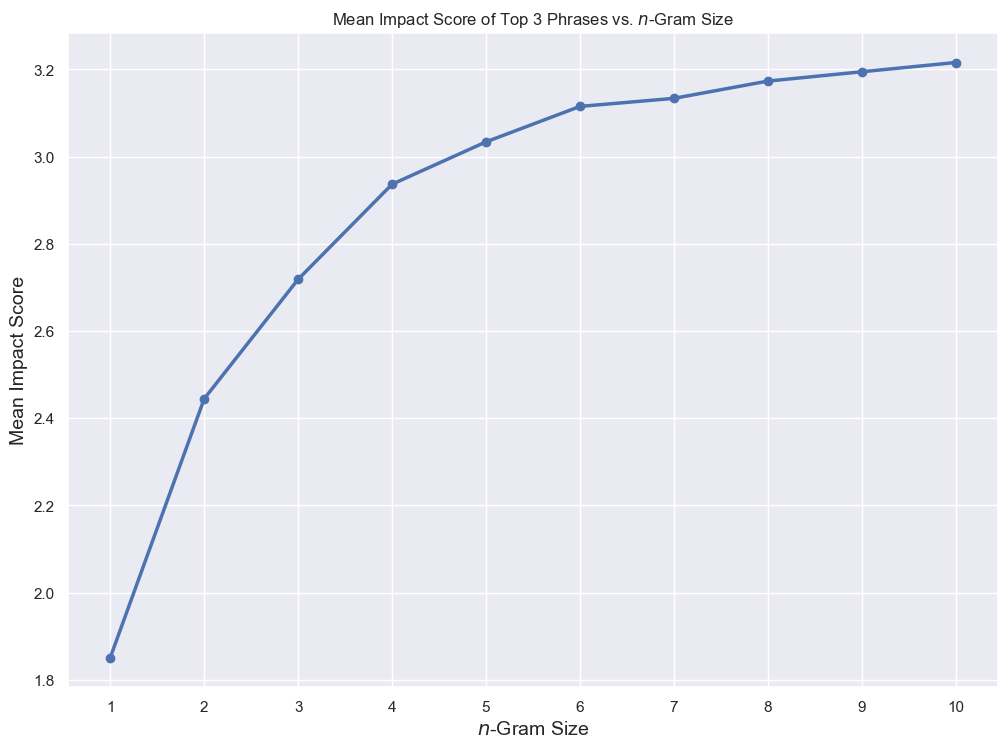

In [20]:
sns.set()
plt.figure(figsize=(12, 8.5))
plt.plot(range(1, 11), means_top_3_list, marker='o', linestyle='-', lw=2.5)
plt.title("Mean Impact Score of Top 3 Phrases vs. $n$-Gram Size")
plt.xlabel("$n$-Gram Size", fontsize=14)
plt.ylabel("Mean Impact Score", fontsize=14)
#plt.grid(True)
plt.xticks(range(1, 11))
plt.show()